## Task 3: Modeling the Angle Sensor


### 3.1 Description

This section condiseders the modeling of an angle sensor for the knee as an algebraic model.

A potentiometer is chosen as sensor.

The measurement range for the angle sensor is chosen according to the range of motion of the knee, which is provided from the gait data.

The poteniometer requires a supply voltage $V_{in}$ of $5$ V and has an integrated µ-controller which has a maximum voltage input range of $3$ V.

The µ-controller uses an 8-bit analog digital converter for digitization of the input voltage.

| Variable | Discription | Value
|----------|----------|---------|
| $V_{out}$    | Output Voltage   | ...|
| $V_{in}$  | Input Voltage   | $5V$|
|$V_{micro}$ |Input Voltage microcontroller | $3V$ |
| $R_{pot}$   | Variable resistance of Potentiometer  | ...|
|$\alpha_{max}| Angular range of Potentiometer |$270°$|
|$R_{fixed}$ |Fixed resistance | $60k\Omega$ |
|$K_{deg}$ |Knee range of motion| $119.7^\circ$ to $184.9^\circ$ |
|$M$ |Microcontroller 8 bit ADC| 0 to 255 |

![](BoxModelPotentiometer.png)

### Potentiometer in a Measuring Bridge (Wheatstone)

The potentimeter can be used with a measuring bridge, where $Z_i = R_i$ since there is only equivalent current and $R_1$ and $R_2$ correspond to the potentimeter such that

$$R_{pot} = R_1 + R_2$$

![](MeasuringBridge.png)

The amplifier voltage, which is used as input voltag for the µ-controller is given as:

$$U_a = U_0 \cdot \left( \frac{R_2}{R_1+R_2} - \frac{R_4}{R_3+R_4} \right)$$

Substituting $R_{pot} = R_1 + R_2$ yields:

$$U_a = U_0 \cdot \left( \frac{R_2}{R_{pot}} - \frac{R_4}{R_3+R_4} \right)$$

The resistance of the potentimeter depends linearly on the rotation angle $\theta$. $R_1$ and $R_2$ can be rewritten as:

$$R_1 = \frac{\theta}{\theta_{max}} \cdot R_{pot} \quad \quad R_2 = R_{pot} - R_1$$

Inserting these expressions for $R_1$ and $R_2$ yields

$$U_a = U_0 \cdot \left( \frac{R_{pot} - \frac{\theta}{\theta_{max}} \cdot R_{pot} }{R_{pot}} - \frac{R_4}{R_3+R_4} \right)$$

$$U_a = U_0 \cdot \left( 1 - \frac{\theta}{\theta_{max}} - \frac{R_4}{R_3+R_4} \right)$$

Since the the measuring input voltage range must not exceed $3$ V, the resistors $R_3$ and $R_4$ have to be selected such that the maximum and minimum angles to be measured $\theta_{max}$ and $\theta_{min}$ lie within this voltage range.

$$\theta_{min} = 119.7° \approx 0.443 \cdot \alpha_{max} \quad \quad \theta_{max} = 184.9° \approx 0.685 \cdot \alpha_{max}$$

$$\frac{R_4}{R_3 + R_4}  \approx 0.443 $$

We set $R_4 = 20 k\Omega$ and obtain
$$R_3 = \frac{1-0.443}{0.443} \cdot R_4 = 25.15  \space k \Omega$$

Hence, we obtain for $U_a$:

$$U_a = U_0 \cdot \left( 1 - 0.443 - \frac{\theta}{\alpha_{max}} \right) = U_0 \cdot \left( 0.557 - \frac{\theta}{\alpha_{max}} \right)$$

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load the data from the Excel file
df = pd.read_excel('gait_data.xls', header=0, engine='xlrd')
Flex_Ext_K = np.array(df['Flex_Ext_K[deg]'])
Flex_Ext_K.sort()

# Check maximum and minimum angles of knee
theta_max = round(Flex_Ext_K.max(), 2)
theta_min = round(Flex_Ext_K.min(), 2)

print(f"Maximum angle of knee (extension): {theta_max}°")
print(f"Minimum angle of knee (flexion):   {theta_min}°")

Maximum angle of knee (extension): 184.93°
Minimum angle of knee (flexion):   119.77°


In [8]:
alpha_pot_max = 270 # angular range of the potentiometer

frac_min = theta_min / alpha_pot_max
frac_max = theta_max / alpha_pot_max

print(f"Fraction of the potentiometer range: {frac_max:.4f}")

R4 = 20e3 # 10 kOhm
R3 = (1 - frac_min) / frac_min * R4

print(f"Value of R3: {R3/1e3:.2f} kOhm")

Fraction of the potentiometer range: 0.6849
Value of R3: 25.09 kOhm


In [9]:
U0 = 5 # Supply voltage

theta_vals = Flex_Ext_K
# theta_vals = np.linspace(theta_min, theta_max, 1000)

# Lambda function for the voltage Ua as a function of the angle alpha 
Ua = lambda alpha: U0 * ( frac_max - alpha / (alpha_pot_max )) # V
Ua_vals = Ua(theta_vals)

In [10]:
# 8 bit ADC Converter
levels = 2**8 # 8 bit
U_mc = 3 # V

Voltage_resolution = U_mc / levels # V / level
digitized_levels = np.round(Ua_vals / Voltage_resolution)
Ua_vals_digital = digitized_levels * Voltage_resolution

error = np.abs(Ua_vals - Ua_vals_digital) / Ua_vals

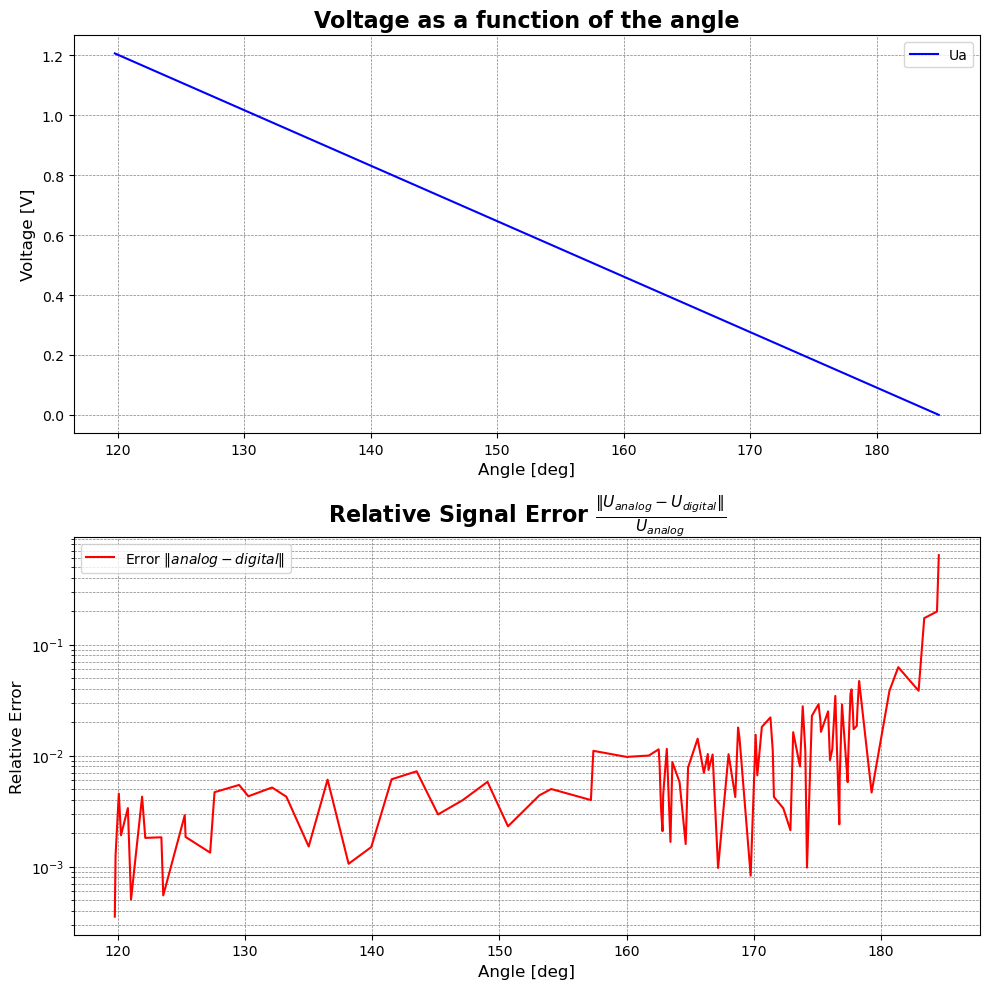

In [12]:
# Plot the results use subplots

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(theta_vals, Ua_vals, label='Ua', color='blue')
ax[0].set_xlabel('Angle [deg]', fontsize=12)
ax[0].set_ylabel('Voltage [V]', fontsize=12)
ax[0].set_title('Voltage as a function of the angle', fontsize=16, fontweight='bold')
ax[0].grid(which='both', axis='both', linestyle='--', color='gray', linewidth=0.5)
ax[0].legend()

ax[1].semilogy(theta_vals[:-1], error[:-1], label=r'Error $\|analog - digital\|$', color='red')
ax[1].set_xlabel('Angle [deg]', fontsize=12)
ax[1].set_ylabel('Relative Error', fontsize=12)
ax[1].set_title(r'Relative Signal Error $\frac{\|U_{analog} - U_{digital}\|}{U_{analog}}$', fontsize=16, fontweight='bold')
ax[1].grid(which='both', axis='both', linestyle='--', color='gray', linewidth=0.5)
ax[1].legend()

plt.tight_layout()
plt.show()